In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image

from skimage import data
from skimage.filters import threshold_otsu, threshold_local
import skimage.filters as filters


Load image and convert it into grayscale

In [2]:
img = cv2.imread('image1.jpeg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
cv2.imwrite('gray.jpeg',gray)
cv2.imwrite('thresh.jpeg',thresh)

True

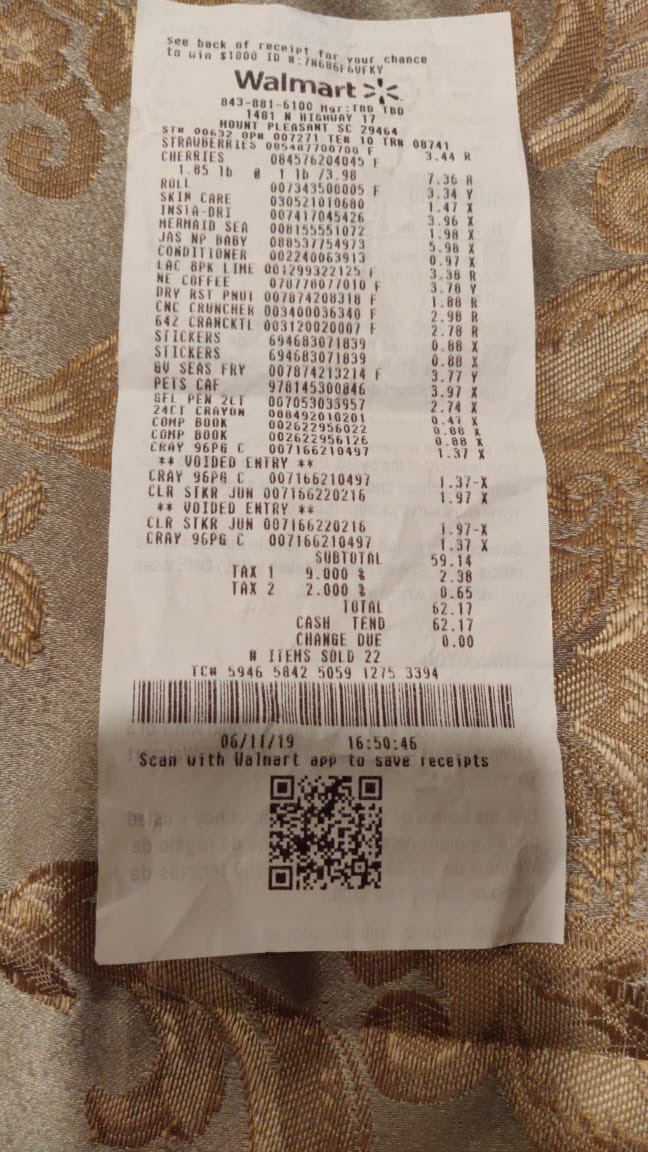

In [3]:
Image.open('image1.jpeg')

apply threshold function

In [4]:
img = cv2.imread('image1.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


text_threshold = threshold_local(img,block_size=21, offset=8) 
cv2.imwrite('threshold.jpeg',text_threshold)


True

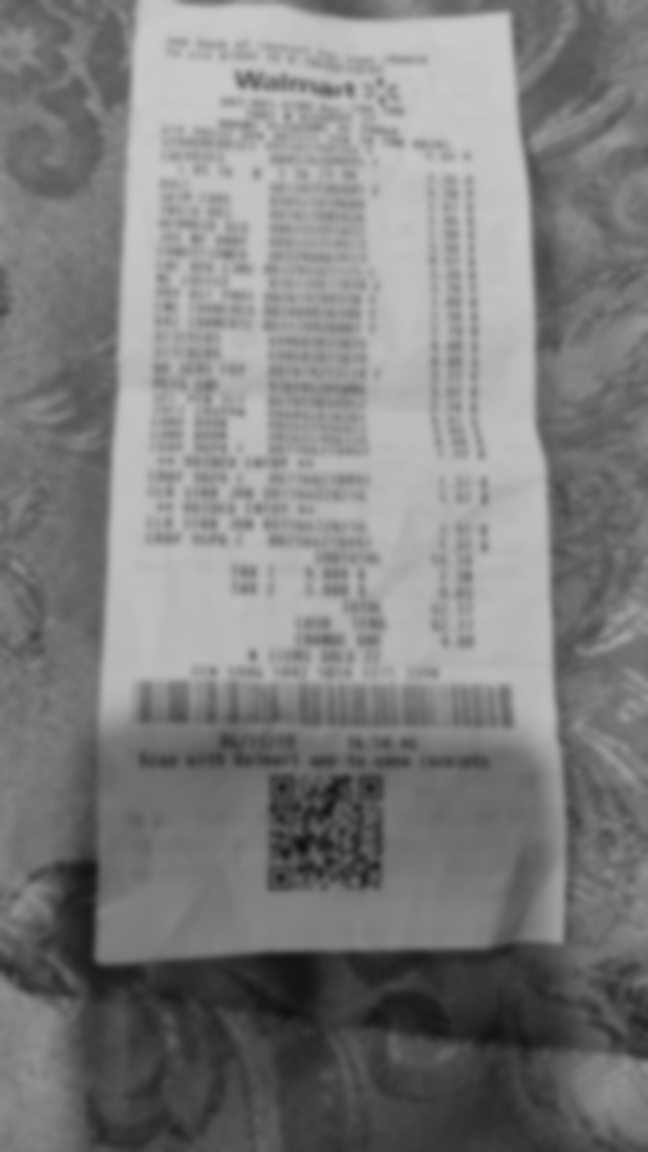

In [5]:
Image.open('threshold.jpeg')

# Image Segmentation and watershed algorithm

In [6]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('image1.jpeg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)
cv2.imwrite('thresh.jpeg',thresh)

True

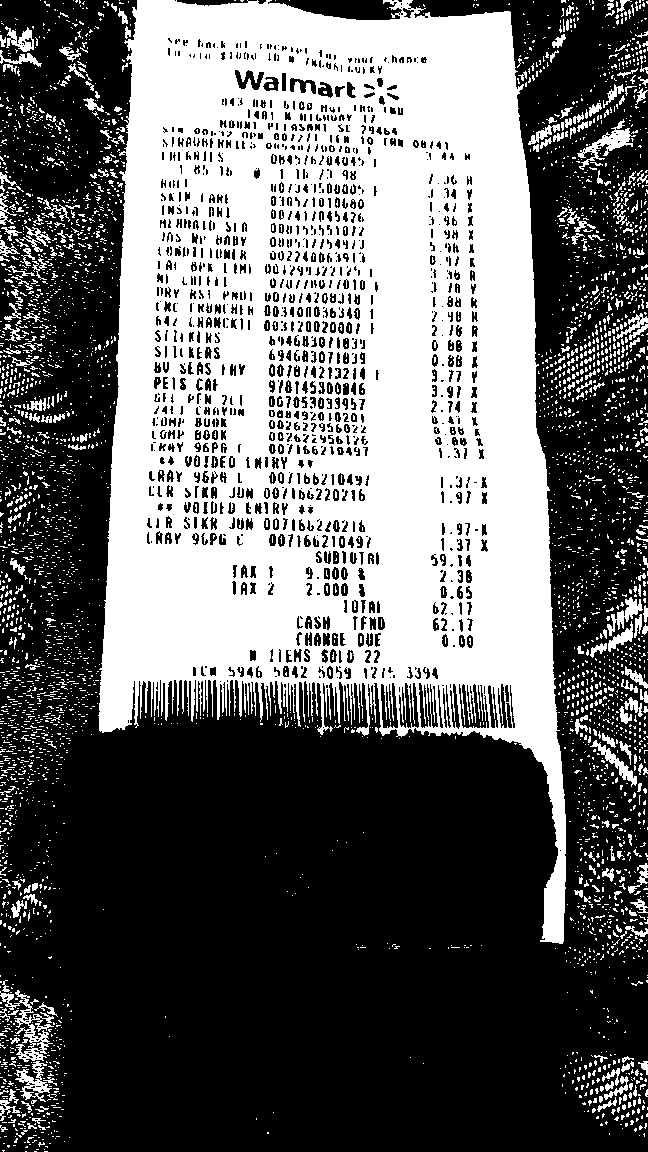

In [7]:
Image.open('thresh.jpeg')

In [8]:
from skimage import morphology
cleaned = morphology.remove_small_objects(thresh, min_size=2000, connectivity=5)
cv2.imwrite('clean.jpeg',cleaned)

True

In [9]:
import numpy as np
import imutils
import cv2
 
def is_contour_bad(c):
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
# the contour is 'bad' if it is not a rectangle
    return not len(approx) == 4

In [10]:
image = cv2.imread("image1.jpeg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edged = cv2.Canny(gray, 50, 100)
#cv2.imshow("Original", image)
 
# find contours in the image and initialize the mask that will be
# used to remove the bad contours
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
mask = np.ones(image.shape[:2], dtype="uint8") * 255
 
# loop over the contours
for c in cnts:
# if the contour is bad, draw it on the mask
    if is_contour_bad(c):
        cv2.drawContours(mask, [c], -1, 0, -1)
 
# remove the contours from the image and show the resulting images
image = cv2.bitwise_and(image, image, mask=mask)
cv2.imwrite("Mask.jpeg", image)

#cv2.imshow("After", image)
#cv2.waitKey(0)

True

In [11]:
# noise removal
# noise removal
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)
cv2.imwrite('open.jpeg',opening)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=1)
cv2.imwrite('sure_background.jpeg',sure_bg)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
cv2.imwrite('sure_foreground.jpeg',sure_fg)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
cv2.imwrite('unknown.jpeg',unknown)

True

In [12]:
img = cv2.imread('thresh.jpeg')
blur = cv2.GaussianBlur(img, (15, 15), 2)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
cv2.imwrite('hsv.jpeg',hsv)
lower_white = np.array([0,0,0], dtype=np.uint8)
upper_white = np.array([0,0,255], dtype=np.uint8)
mask = cv2.inRange(hsv, lower_white, upper_white)
cv2.imwrite('white.jpeg',mask)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
opened_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
masked_img = cv2.bitwise_and(img, img, mask=mask)
cv2.imwrite('masked.jpeg',masked_img)

#cv2.imshow('', masked_img)
#cv2.waitKey()

True

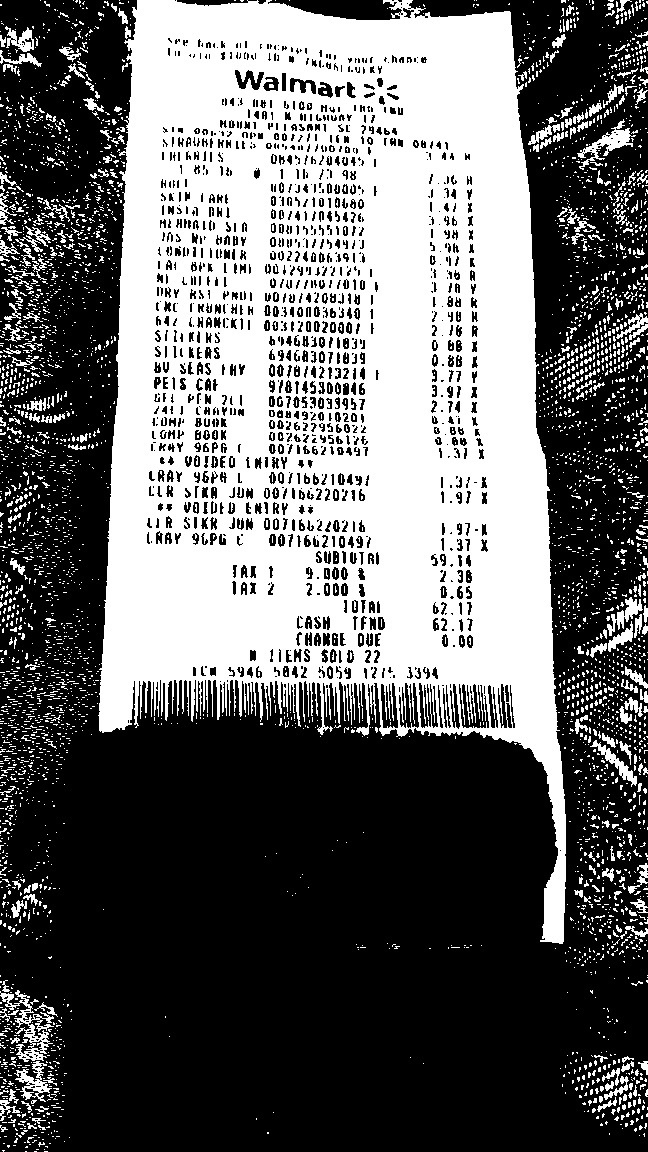

In [13]:
Image.open('masked.jpeg')

connect components

In [14]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0



Apply Watershed algorithm

In [15]:
markers = cv2.watershed(img,markers)
img[markers ==-1] = [255,0,0]
cv2.imwrite('marker.jpeg',img)

True

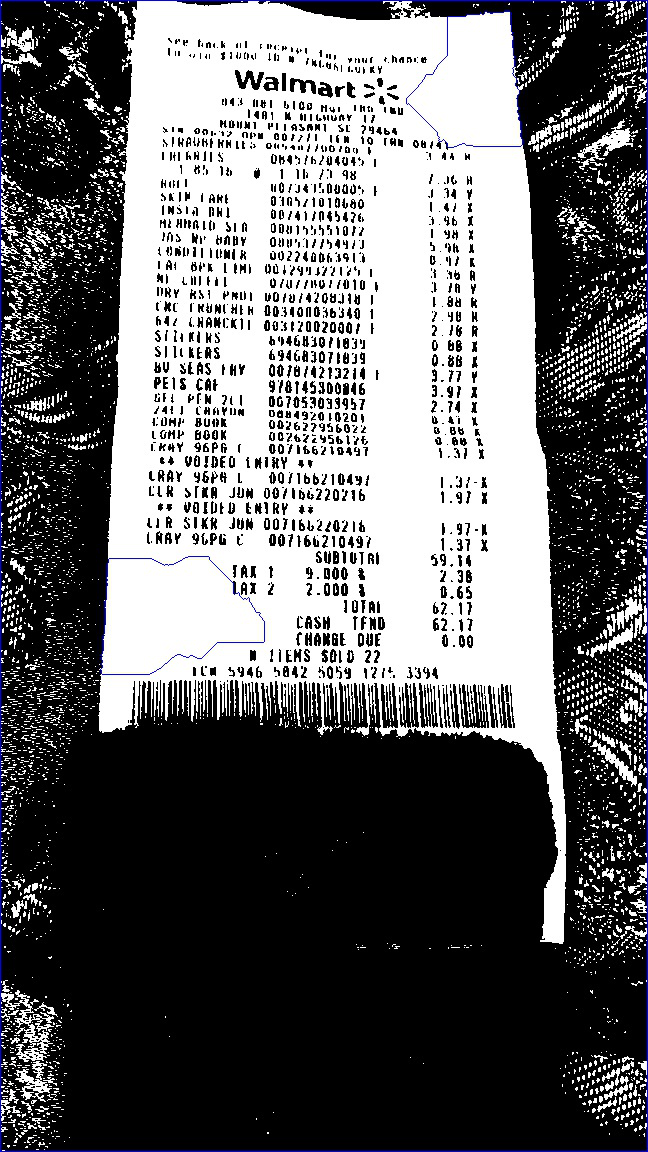

In [16]:
Image.open('marker.jpeg')

Apply four point transformation for marker.jpeg

In [17]:
img2=Image.open('marker.jpeg')


In [18]:
import numpy as np
import cv2
 
def order_points(pts):

    rect = np.zeros((4, 2), dtype = "float32")


    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]


    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

In [19]:
def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect


    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))


    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))


    dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))


    return warped

In [20]:
import numpy as np
import argparse
import cv2
import imutils

#from pyimagesearch.transform import four_point_transform
from skimage.filters import threshold_local

Step1 Edge detection

In [21]:
import cv2


image = cv2.imread("marker.jpeg")
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)
 
# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

 
# show the original image and the edge detected image
#print("STEP 1: Edge Detection")
#cv2.imshow("Image", image)
#cv2.imshow("Edged", edged)
cv2.imwrite('edge.jpeg',edged)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

True

Find Contours

In [22]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
 
# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
#if our approximated contour has four points, then we
# can assume that we have found our screen
    if len(approx) == 4:
        screenCnt = approx
        break
 
# show the contour (outline) of the piece of paper
screenCnt=approx
#print("STEP 2: Find contours of paper")
contour=cv2.drawContours(image, approx, -1,(0, 255, 0), 2)
#cv2.imshow("Outline", image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
cv2.imwrite("cannyedge.jpeg",contour)

True

Apply Four Point Transform

In [23]:
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
 
# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255
 
# show the original and scanned images
#print("STEP 3: Apply perspective transform")
#cv2.imshow("Original", imutils.resize(orig, height = 650))
#cv2.imshow("Scanned", imutils.resize(warped, height = 650))
#cv2.waitKey(0)
cv2.imwrite('wrap.jpeg',warped)

True

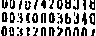

In [24]:
Image.open('wrap.jpeg')

IMplementation of GRABCUT ALGORITHM FOR FOREGROUND EXTRACTION

In [25]:
# Python program to illustrate 
# foreground extraction using 
# GrabCut algorithm 

# organize imports 
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 

# path to input image specified and 
# image is loaded with imread command 
image = cv2.imread('image1.jpeg') 

# create a simple mask image similar 
# to the loaded image, with the 
# shape and return type 
mask = np.zeros(image.shape[:2], np.uint8) 

# specify the background and foreground model 
# using numpy the array is constructed of 1 row 
# and 65 columns, and all array elements are 0 
# Data type for the array is np.float64 (default) 
backgroundModel = np.zeros((1, 65), np.float64) 
foregroundModel = np.zeros((1, 65), np.float64) 

# define the Region of Interest (ROI) 
# as the coordinates of the rectangle 
# where the values are entered as 
# (startingPoint_x, startingPoint_y, width, height) 
# these coordinates are according to the input image 
# it may vary for different images 
rectangle = (60, 80, 400, 800) 

# apply the grabcut algorithm with appropriate 
# values as parameters, number of iterations = 3 
# cv2.GC_INIT_WITH_RECT is used because 
# of the rectangle mode is used 
cv2.grabCut(image, mask, rectangle,backgroundModel, foregroundModel, 3, cv2.GC_INIT_WITH_RECT) 

# In the new mask image, pixels will 
# be marked with four flags 
# four flags denote the background / foreground 
# mask is changed, all the 0 and 2 pixels 
# are converted to the background 
# mask is changed, all the 1 and 3 pixels 
# are now the part of the foreground 
# the return type is also mentioned, 
# this gives us the final mask 
mask2 = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8') 

# The final mask is multiplied with 
# the input image to give the segmented image. 
image = image * mask2[:, :, np.newaxis] 

# output segmented image with colorbar 
cv2.imwrite("image.jpeg",image)


True

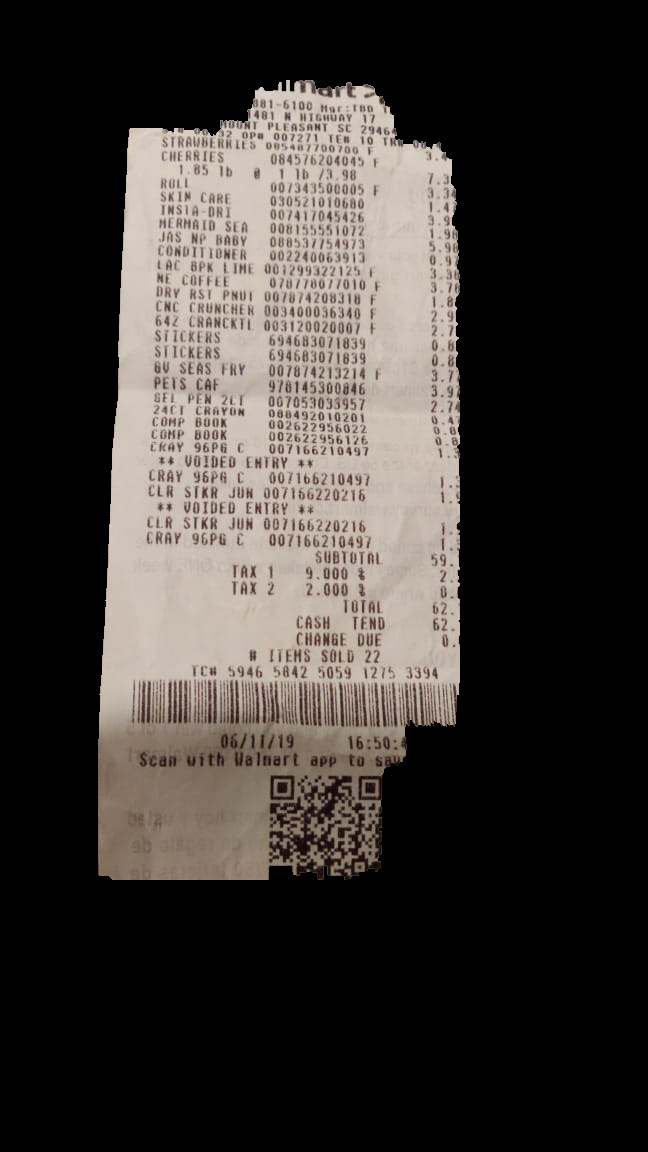

In [26]:
Image.open("image.jpeg")


In [27]:
img = cv2.imread('image.jpeg')
Image.open('image.jpeg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
x,y,w,h = cv2.boundingRect(cnt)
crop = img[y:y+h,x:x+w]
cv2.imwrite('cropped.jpeg',crop)

True

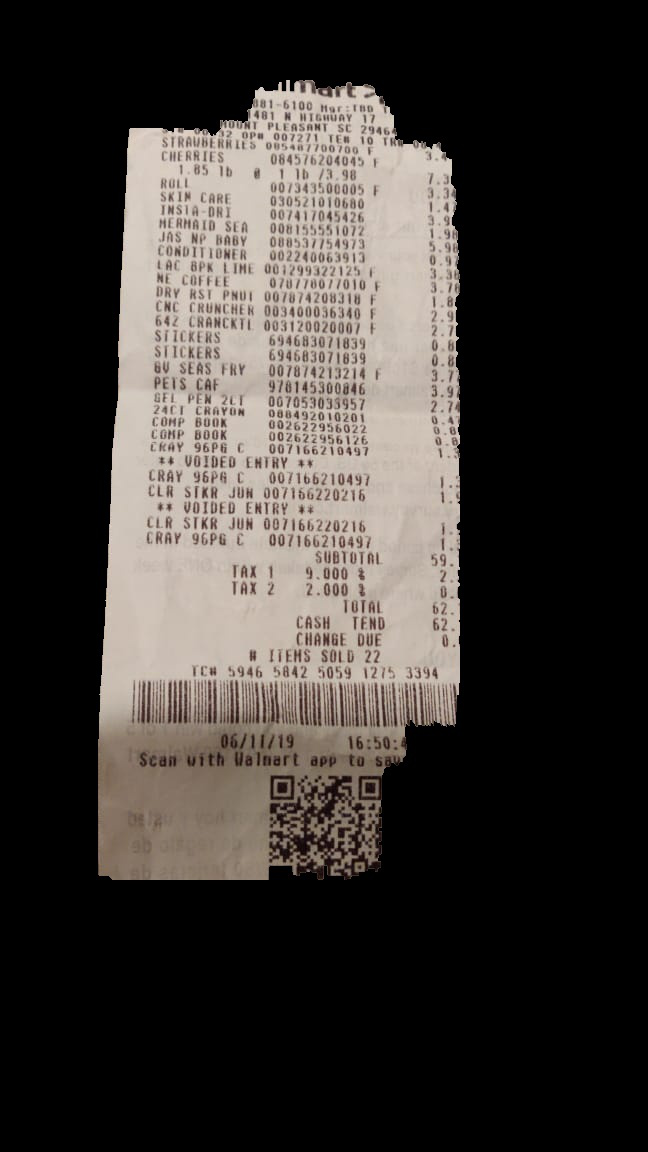

In [28]:
Image.open('cropped.jpeg')

In [ ]:

img=cv2.imread("image.jpeg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
rows=gray.shape[0]
cols=gray.shape[1]
for i in range(rows):
    
      for j in range(cols):
            
             k = img[i,j]
             print(k)

In [ ]:
import pandas as pd
import numpy as np
import 